# COURSE: PCA and multivariate neural signal processing
## SECTION: Overfitting and inferential statistics
### VIDEO: Permutation testing
#### Instructor: sincxpress.com

In [1]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
import scipy.io as sio
from mpl_toolkits.mplot3d import Axes3D
from pytopo import topoplotIndie

from scipy.stats import norm # for z-to-p

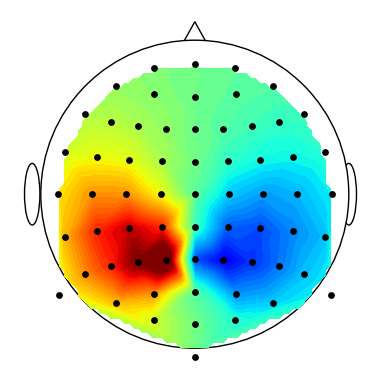

In [3]:
## simulate data

# mat file containing EEG, leadfield and channel locations
matfile = sio.loadmat('MATLAB_data_files/emptyEEG')
EEG = matfile['EEG'][0,0]
lf  = matfile['lf'][0,0]

# adjust some parameters
EEG['srate']  = 500
EEG['trials'] = 200
EEG['pnts']   = 1000
EEG['times']  = np.arange(EEG['pnts']) / EEG['srate']
EEG['data']   = np.zeros( (EEG['nbchan'][0][0],EEG['pnts'],EEG['trials']) )

# index of dipole to simulate activity in
dipoleLoc1 = 108

# show dipole projection map
topoplotIndie(lf['Gain'][:,1,dipoleLoc1],EEG['chanlocs'])

In [4]:
## insert activity waveforms into dipole data

# frequencies of the two dipoles
freq1 = 10

# time point of "stimulus" onset
tidx = np.argmin( np.abs(EEG['times']-np.mean(EEG['times'])) )

# the "innards" of the sine function
omega1 = 2*np.pi*freq1*EEG['times'][tidx:]

lfsize = np.shape(lf['Gain'])

# loop over trials
for ti in range(EEG['trials']):
    
    # source waveforms (sine waves with random phase)
    swave1 = np.sin( omega1 + np.random.rand(1)*2*np.pi )
    
    dipole_data = np.random.randn(EEG['pnts'],lfsize[2])/5
    dipole_data[tidx:,dipoleLoc1] += swave1
    
    # project to scalp
    EEG['data'][:,:,ti] = ( dipole_data@lf['Gain'][:,1,:].T ).T


In [5]:
## GED for spatial filter

covPre = np.zeros( (int(EEG['nbchan']),int(EEG['nbchan'])) )
covPst = np.zeros( (int(EEG['nbchan']),int(EEG['nbchan'])) )


# covariance matrices per trial
for ti in range(int(EEG['trials'])):
    
    # "prestim" covariance
    tdat = EEG['data'][:,:tidx,ti]
    for ci in range(int(EEG['nbchan'])):
        tdat[ci,:] -= np.mean(tdat[ci,:])
    covPre += (tdat@tdat.T) / EEG['pnts']
    
    
    # "post-stim" covariance
    tdat = EEG['data'][:,tidx:,ti]
    for ci in range(int(EEG['nbchan'])):
        tdat[ci,:] -= np.mean(tdat[ci,:])
    covPst += (tdat@tdat.T) / EEG['pnts']
    

covPre = covPre/ti
covPst = covPst/ti

# GED
evals,evecs = scipy.linalg.eigh(covPst,covPre)
# sort according to eigenvalues
soidx = np.argsort(evals)[::-1]
evals = evals[soidx]
evecs = evecs[:,soidx]


#### compute filter forward models and flip sign

# component 1:
map1 = evecs[:,0].T@covPst # get component
idx  = np.argmax(np.abs(map1)) # find max magnitude
map1 = map1*np.sign(map1[idx])  # possible sign flip


### compute component time series (projections)
cdat = evecs[:,0].T @ np.reshape(EEG['data'], (EEG['nbchan'][0][0],-1), order='F' )
cdat = np.reshape(cdat, (EEG['pnts'],EEG['trials']),order='F')

In [6]:
## permutation testing

nPermutes = 500

# initialize matrix of eigenvalues under the null hypothesis
pevals = np.zeros( (nPermutes,EEG['nbchan'][0][0]) )

# loop over permutations
for permi in range(nPermutes):
    
    # time vector with random start time
    cutidx = int( np.random.rand()*EEG['pnts'] )
    tidx = np.hstack( (np.arange(cutidx,EEG['pnts']),np.arange(cutidx)) )
    halft  = int(EEG['pnts']/2)
    # use tidx(1:halft) and tidx(halft+1:end)
    
    
    # reinitialize covariance matrices
    covPre = np.zeros((EEG['nbchan'][0][0],EEG['nbchan'][0][0]))
    covPst = np.zeros((EEG['nbchan'][0][0],EEG['nbchan'][0][0]))
    
    # covariance matrices per trial
    for ti in range(EEG['trials']):
        
        # "prestim" covariance
        tdat = EEG['data'][:,tidx[:halft],ti]
        covPre += np.cov(tdat)
        
        # "post-stim" covariance
        tdat = EEG['data'][:,tidx[halft:],ti]
        covPst += np.cov(tdat)
    
    # GED
    pevals[permi,:] = np.sort( scipy.linalg.eigh(covPst,covPre)[0] )[::-1]


# inferential statistics for first component
zval = (evals[0]-np.mean(pevals[:,0])) / np.std(pevals[:,0])
pval = scipy.stats.norm.cdf(-np.abs(zval))

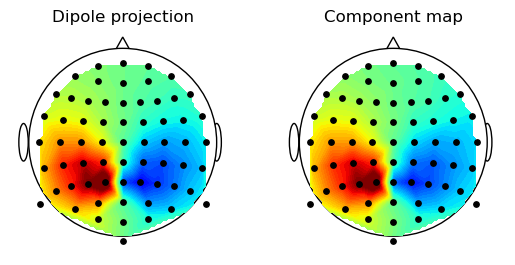

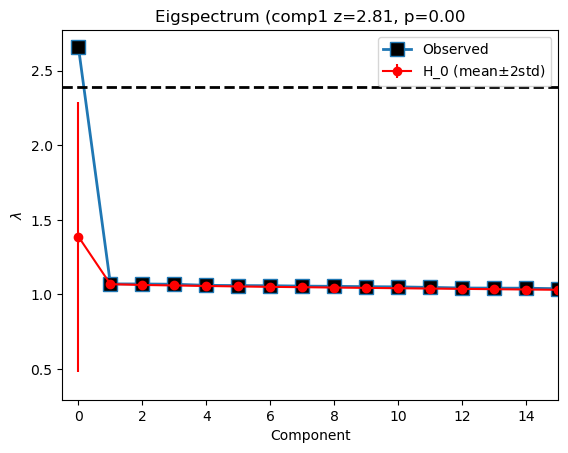

In [7]:
## show topographical maps and eigenspectrum

# maps
_,axs = plt.subplots(1,2)
topoplotIndie(lf['Gain'][:,1,dipoleLoc1],EEG['chanlocs'],'Dipole projection',axs[0])
topoplotIndie(map1,EEG['chanlocs'],'Component map',axs[1])
plt.show()


# eigenspectra
plt.plot(evals,'s-',linewidth=2,markersize=10,markerfacecolor='k')

# add mean and spread of null distributions
plt.errorbar(np.arange(64),np.mean(pevals,axis=0),yerr=2*np.std(pevals,axis=0),color='r',marker='o')
plt.legend(['Observed','H_0 (mean$\pm$2std)'])
plt.xlim([-.5,15])
plt.xlabel('Component')
plt.ylabel('$\lambda$')
plt.title(f'Eigspectrum (comp1 z={zval:.2f}, p={pval:.2f}')

eigvalCrit = np.percentile(pevals[:,0],95)
plt.plot([-.5,15],[eigvalCrit,eigvalCrit],'k--',linewidth=2)

plt.show()
